In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import label encoder 
from sklearn import preprocessing 

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor # multi layer perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pylab
import math

https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

In [2]:
# importing dataset
data = pd.read_csv("Dataset.csv", encoding='cp1252')
data

,Name,Car Spaces,Bedrooms,Bathrooms,Floor area (m2),Land Size(m2),Waterfront,Location,Price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1.0,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1.0,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1.0,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0.0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0.0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
350,House and Lot for Sale in Salinas Dr. Ext. Lah...,2.0,7.0,6.0,500.0,951.0,0.0,Cebu,50000000.0
351,House & Lot in Botanika Residence Townhouse & ...,2.0,3.0,2.0,200.0,200.0,0.0,Cebu,10800000.0
352,"House and Lot for Sale at Lapu-Lapu, Cebu in M...",1.0,4.0,2.0,360.0,360.0,0.0,Cebu,5500000.0
353,"House for Sale in White Sands, Maribago Mactan...",1.0,5.0,4.0,500.0,316.0,NaN,Lapu Lapu,16000000.0


In [3]:
# renaming columns
data.columns = ['name', 'carspaces', 'bedrooms', 'bathrooms', 'floorarea', 'landsize', 'waterfront', 'location', 'price']

In [4]:
data[data['name'].duplicated() == True]

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
86,"House for sale at Tres de Abril St., Punta Pri...",4.0,5.0,5.0,328.00,200.5,0.0,Cebu,22850000.0
107,House and Lot for Sale in Maryville Subdivisio...,1.0,4.0,4.0,185.00,250.0,NaN,Cebu,15000000.0
119,Briella (RFO) 2 storey single detached with ba...,2.0,5.0,4.0,210.00,180.0,NaN,Minglanilla,9133966.0
139,4Br House and Lot For Sale in Banawa Cebu City,2.0,4.0,4.0,114.00,75.0,NaN,Cebu,8652000.0
151,Furnished 3 Bedroom House for Sale near Cebu I...,1.0,3.0,3.0,200.00,140.0,NaN,Cebu,18000000.0
156,2 BR-RFO TOWNHOUSE WITH 2 T&B AND 1 CARPORT/lo...,1.0,2.0,2.0,65.00,40.0,NaN,Minglanilla,3500000.0
189,Two Storey House Villa with Pool - Camotes Isl...,NaN,3.0,2.0,385.40,1500.0,1.0,Camotes,11900000.0
204,"10-Bedroom House and Lot for Sale, Cebu City",NaN,10.0,10.0,527.00,267.0,0.0,Cebu,20000000.0
214,"1 Bedroom Townhouse in Agus, Lapu-Lapu City",NaN,1.0,1.0,54.00,35.0,0.0,Lapu-Lapu,1500000.0
221,Beautiful exclusive pocket subdivision in Pobl...,1.0,3.0,2.0,61.00,59.0,0.0,Cebu,4200000.0


In [5]:
data.drop_duplicates(subset = ["name"], keep = 'first', inplace = True) 
data[data['name'].duplicated() == True]

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price


In [6]:
data

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.0,2.0,3.0,150.0,173.0,1.0,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.0,3.0,2.0,80.0,291.0,1.0,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.0,3.0,2.0,385.4,1500.0,1.0,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.0,5.0,5.0,360.0,462.0,0.0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.0,4.0,3.0,103.0,60.0,0.0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
350,House and Lot for Sale in Salinas Dr. Ext. Lah...,2.0,7.0,6.0,500.0,951.0,0.0,Cebu,50000000.0
351,House & Lot in Botanika Residence Townhouse & ...,2.0,3.0,2.0,200.0,200.0,0.0,Cebu,10800000.0
352,"House and Lot for Sale at Lapu-Lapu, Cebu in M...",1.0,4.0,2.0,360.0,360.0,0.0,Cebu,5500000.0
353,"House for Sale in White Sands, Maribago Mactan...",1.0,5.0,4.0,500.0,316.0,NaN,Lapu Lapu,16000000.0


In [7]:
# check for null values
display(data.isnull().any())

name          False
carspaces      True
bedrooms       True
bathrooms      True
floorarea      True
landsize       True
waterfront     True
location      False
price          True
dtype: bool

In [8]:
# identify the mean of carspaces column to fill in null columns
data['carspaces'].mean()

2.0673076923076925

In [9]:
# # filling null values
data[['carspaces']] = data[['carspaces']].fillna(data['carspaces'].mean())
display(data.isnull().any())

name          False
carspaces     False
bedrooms       True
bathrooms      True
floorarea      True
landsize       True
waterfront     True
location      False
price          True
dtype: bool

In [10]:
data[['bedrooms']] = data[['bedrooms']].fillna(data['bedrooms'].mean())
data[['bathrooms']] = data[['bathrooms']].fillna(data['bathrooms'].mean())
data[['floorarea']] = data[['floorarea']].fillna(data['floorarea'].mean())
data[['landsize']] = data[['landsize']].fillna(data['landsize'].mean())
data[['waterfront']] = data[['waterfront']].fillna('0')
display(data.isnull().any())

name          False
carspaces     False
bedrooms      False
bathrooms     False
floorarea     False
landsize      False
waterfront    False
location      False
price          True
dtype: bool

In [11]:
display(data.isnull().any())

name          False
carspaces     False
bedrooms      False
bathrooms     False
floorarea     False
landsize      False
waterfront    False
location      False
price          True
dtype: bool

In [12]:
# now, the price has the only column that contains null values
# we will be remove those rows with null prices since we are predicting the prices for house sales
data.dropna(axis = 0, how = 'any', inplace = True)
data

,name,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,Bungalow House & Lot for sale in Lapu-Lapu Cit...,2.000000,2.0,3.0,150.0,173.0,1,Lapu-Lapu,3800000.0
1,Ready for occupancy single detached Beach house,1.000000,3.0,2.0,80.0,291.0,1,Argao,7078000.0
2,Two Storey House Villa with Pool - Camotes Isl...,5.000000,3.0,2.0,385.4,1500.0,1,Camotes Island,11900000.0
3,A Luxury 5-Bedroom Resort-Style Home,4.000000,5.0,5.0,360.0,462.0,0,Lapu-Lapu,52000000.0
4,"Townhouse for Sale in Banilad, Mandaue City",1.000000,4.0,3.0,103.0,60.0,0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...,...
350,House and Lot for Sale in Salinas Dr. Ext. Lah...,2.000000,7.0,6.0,500.0,951.0,0,Cebu,50000000.0
351,House & Lot in Botanika Residence Townhouse & ...,2.000000,3.0,2.0,200.0,200.0,0,Cebu,10800000.0
352,"House and Lot for Sale at Lapu-Lapu, Cebu in M...",1.000000,4.0,2.0,360.0,360.0,0,Cebu,5500000.0
353,"House for Sale in White Sands, Maribago Mactan...",1.000000,5.0,4.0,500.0,316.0,0,Lapu Lapu,16000000.0


In [13]:
data.drop('name', axis = 1, inplace = True)
data

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.000000,2.0,3.0,150.0,173.0,1,Lapu-Lapu,3800000.0
1,1.000000,3.0,2.0,80.0,291.0,1,Argao,7078000.0
2,5.000000,3.0,2.0,385.4,1500.0,1,Camotes Island,11900000.0
3,4.000000,5.0,5.0,360.0,462.0,0,Lapu-Lapu,52000000.0
4,1.000000,4.0,3.0,103.0,60.0,0,Mandaue,10500000.0
...,...,...,...,...,...,...,...,...
350,2.000000,7.0,6.0,500.0,951.0,0,Cebu,50000000.0
351,2.000000,3.0,2.0,200.0,200.0,0,Cebu,10800000.0
352,1.000000,4.0,2.0,360.0,360.0,0,Cebu,5500000.0
353,1.000000,5.0,4.0,500.0,316.0,0,Lapu Lapu,16000000.0


In [14]:
# identify if the location values are all provinces
location_list = data.location.unique()
location_list

array(['Lapu-Lapu', 'Argao', 'Camotes Island', 'Mandaue', 'Cebu',
       'Consolacion', 'Bogo', 'Oslob', 'Talisay', 'Liloan', 'Medellin',
       'Compostela', 'Minglanilla', 'Alcoy', 'Lapu-lapu', 'Cordova',
       'Toledo', 'Talamban', 'Borbon', 'Bantayan', 'Santander', 'Badian',
       'Banilad', 'Guadalupe', 'Naga', 'Lahug', 'Danao', 'Carcar',
       'Catmon', 'Guadalupe, Cebu', 'Carmen', ' Carcar', 'Lapu-Lapu ',
       'Lapu Lapu'], dtype=object)

In [15]:
data.loc[data['location'].str.contains('Guadalupe'), 'location'] = 'Cebu'
data.loc[data['location'].str.contains('Cordova'), 'location'] = 'Lapu-Lapu'
data.loc[data['location'].str.contains('Camotes'), 'location'] = 'Camotes Island'
data.loc[data['location'].str.contains('Bantayan'), 'location'] = 'Bantayan Island'
data.loc[data['location'].str.contains('Lapu-lapu'), 'location'] = 'Lapu-Lapu'
data.loc[data['location'].str.contains('Carcar'), 'location'] = 'Carcar'
data.loc[data['location'].str.contains('Banilad'), 'location'] = 'Cebu'

In [16]:
# sorting the list
location_list = data.location.unique()
location_list.sort()
location_list

array(['Alcoy', 'Argao', 'Badian', 'Bantayan Island', 'Bogo', 'Borbon',
       'Camotes Island', 'Carcar', 'Carmen', 'Catmon', 'Cebu',
       'Compostela', 'Consolacion', 'Danao', 'Lahug', 'Lapu Lapu',
       'Lapu-Lapu', 'Lapu-Lapu ', 'Liloan', 'Mandaue', 'Medellin',
       'Minglanilla', 'Naga', 'Oslob', 'Santander', 'Talamban', 'Talisay',
       'Toledo'], dtype=object)

In [17]:
# identify the number of provinces in the dataset composed of 27 provinces
len(location_list)

28

In [18]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

In [19]:
# Encode labels in column 'location'. 
# This converts the categorical into numerical
data['location']= label_encoder.fit_transform(data['location']) 
data

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.000000,2.0,3.0,150.0,173.0,1,16,3800000.0
1,1.000000,3.0,2.0,80.0,291.0,1,1,7078000.0
2,5.000000,3.0,2.0,385.4,1500.0,1,6,11900000.0
3,4.000000,5.0,5.0,360.0,462.0,0,16,52000000.0
4,1.000000,4.0,3.0,103.0,60.0,0,19,10500000.0
...,...,...,...,...,...,...,...,...
350,2.000000,7.0,6.0,500.0,951.0,0,10,50000000.0
351,2.000000,3.0,2.0,200.0,200.0,0,10,10800000.0
352,1.000000,4.0,2.0,360.0,360.0,0,10,5500000.0
353,1.000000,5.0,4.0,500.0,316.0,0,15,16000000.0


In [20]:
data = data.astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321 entries, 0 to 354
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   carspaces   321 non-null    float64
 1   bedrooms    321 non-null    float64
 2   bathrooms   321 non-null    float64
 3   floorarea   321 non-null    float64
 4   landsize    321 non-null    float64
 5   waterfront  321 non-null    float64
 6   location    321 non-null    float64
 7   price       321 non-null    float64
dtypes: float64(8)
memory usage: 22.6 KB


In [21]:
# calculate the correlation matrix
corr = data.corr()

In [22]:
# define two data frames one before the drop and one after the drop
data_before = data

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(data_before)

# create the series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

# display the series
print('Current VFI')
display(series_before)

Current VFI


const         15.220806
carspaces      1.405296
bedrooms       1.523537
bathrooms      1.686308
floorarea      2.841199
landsize       1.120089
waterfront     1.085970
location       1.045971
price          2.548827
dtype: float64

In [23]:
# checking for outliers
# get the summary
desc_df = data.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display the summary
desc_df

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,3.210000e+02
mean,2.077492,3.968522,3.631520,230.490793,363.120623,0.186916,14.348910,1.565256e+07
std,1.080513,1.873906,7.864869,229.884304,797.349420,0.390453,6.060353,2.122730e+07
min,0.000000,1.000000,1.000000,2.000000,35.000000,0.000000,0.000000,1.034000e+06
25%,2.000000,3.000000,2.000000,88.000000,100.000000,0.000000,10.000000,4.950000e+06
50%,2.000000,4.000000,3.000000,155.000000,172.000000,0.000000,12.000000,8.500000e+06
75%,2.067308,5.000000,4.000000,300.000000,337.000000,0.000000,18.000000,1.800000e+07
max,8.000000,18.000000,141.000000,2100.000000,10000.000000,1.000000,27.000000,2.000000e+08
+3_std,5.319030,9.590240,27.226126,920.143704,2755.168882,1.358274,32.529969,7.933445e+07
-3_std,-1.164046,-1.653195,-19.963087,-459.162118,-2028.927636,-0.984442,-3.832150,-4.802934e+07


In [24]:
# filter the data frame to remove the values exceeding 3 standard deviations
remove_df = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

# what rows were removed
data.index.difference(remove_df.index)
print("Number of outliers found: ", len(data)-len(remove_df))

Number of outliers found:  26


In [25]:
data = remove_df

In [26]:
data

,carspaces,bedrooms,bathrooms,floorarea,landsize,waterfront,location,price
0,2.000000,2.0,3.0,150.0,173.0,1.0,16.0,3800000.0
1,1.000000,3.0,2.0,80.0,291.0,1.0,1.0,7078000.0
2,5.000000,3.0,2.0,385.4,1500.0,1.0,6.0,11900000.0
3,4.000000,5.0,5.0,360.0,462.0,0.0,16.0,52000000.0
4,1.000000,4.0,3.0,103.0,60.0,0.0,19.0,10500000.0
...,...,...,...,...,...,...,...,...
350,2.000000,7.0,6.0,500.0,951.0,0.0,10.0,50000000.0
351,2.000000,3.0,2.0,200.0,200.0,0.0,10.0,10800000.0
352,1.000000,4.0,2.0,360.0,360.0,0.0,10.0,5500000.0
353,1.000000,5.0,4.0,500.0,316.0,0.0,15.0,16000000.0


# ---------------- END OF DATA CLEANING ---------------

In [27]:
# instantiate models
modelLR = LinearRegression()
modelNN = MLPRegressor()
modelRF = RandomForestRegressor()

In [28]:
X = data.iloc[ : , 0:7]
Y = data.iloc[ : , 7]

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [30]:
def getScore(modelName, model):
    print(modelName)
    print("Train R-Squared: ", model.score(X_train, Y_train))
    print("Test R-Squared: ", model.score(X_test, Y_test))

In [31]:
# instantiate models
modelLR.fit(X_train, Y_train)
modelNN.fit(X_train, Y_train)
modelRF.fit(X_train, Y_train)

c:\users\ginn\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestRegressor()

In [32]:
getScore("Linear Regression Model", modelLR)
print()
getScore("Multi Layer Perceptron Model", modelNN)
print()
getScore("Random Forest Regression Model", modelRF)

Linear Regression Model
Train R-Squared:  0.6730136129629389
Test R-Squared:  0.5610558383757929

Multi Layer Perceptron Model
Train R-Squared:  -1.0696546182535194
Test R-Squared:  -0.9210248598361226

Random Forest Regression Model
Train R-Squared:  0.9527966531084938
Test R-Squared:  0.5171232206680663


### Identifying Errors

In [33]:
def getErrors(modelName, pred):
#     model_pred = 
    print(modelName)
    e = mean_squared_error(pred, Y_test)
    print("Mean Squared Error (MSE): ", e)
    print("Mean Absolute Error (MAE): ", mean_absolute_error(pred, Y_test))
    print("Root Mean Squared Error (RMSE): ", math.sqrt(e))

In [34]:
LRpred = modelLR.predict(X_test)
NNpred = modelNN.predict(X_test)
RFpred = modelRF.predict(X_test)

In [35]:
getErrors("Linear Regression Model", LRpred)
print()
getErrors("Multi Layer Perceptron Model", NNpred)
print()
getErrors("Random Forest Regression Model", RFpred)

Linear Regression Model
Mean Squared Error (MSE):  53055698633737.055
Mean Absolute Error (MAE):  4177168.159499193
Root Mean Squared Error (RMSE):  7283934.282634423

Multi Layer Perceptron Model
Mean Squared Error (MSE):  232196541023001.72
Mean Absolute Error (MAE):  10553806.74896723
Root Mean Squared Error (RMSE):  15237996.621045751

Random Forest Regression Model
Mean Squared Error (MSE):  58365885962957.89
Mean Absolute Error (MAE):  4086301.875874799
Root Mean Squared Error (RMSE):  7639756.930881891


### Determine Intercept and Coefficients

In [36]:
# let's grab the coefficient of our model and the intercept
print("\n The intercept for our model is {:.4}".format(modelLR.intercept_))
# print('-'*100)

coeff_df = pd.DataFrame(modelLR.coef_, X.columns, columns=['Coefficients'])
coeff_df


 The intercept for our model is -3.313e+06


,Coefficients
carspaces,-9.768399e+04
bedrooms,2.759457e+04
bathrooms,3.062445e+06
floorarea,3.554478e+04
landsize,4.932772e+03
waterfront,1.812190e+06
location,-1.147552e+05


In [37]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

Bottom line: a negative R2 is not a mathematical impossibility or the sign of a computer bug. It simply means that the chosen model (with its constraints) fits the data really poorly.

<span style="color: navy;font-weight: 700;">Test for Heterosecdasticity</span>

    In the Sigma Coding, it suggested to run the White's Test to looking for unique cases to identify the heteroscedasticity. In this case I'll just run the Breush-Pagan's Test which is more general test for heteroscedasticity.

In [38]:
# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypothesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypothesis, so there is heterosecdasticity.")

5.691633473348076e-13 8.423178482522462e-15
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 5.692e-13
We reject the null hypothesis, so there is heterosecdasticity.


<span style="color: navy;font-weight: 700;">Test for Autocorrelation</span>

The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.6738
We fail to reject the null hypothesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


c:\users\ginn\appdata\local\programs\python\python38\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


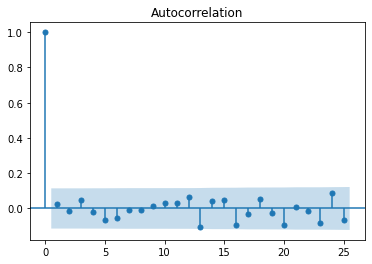

In [39]:
# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypothesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypothesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

In [40]:
# Get multiple predictions
y_predict = modelLR.predict(X_test) 

# Show the first 5 predictions
print("Price for the first 5 predictions: ")
for price in y_predict[:5]:
    print(price)

Price for the first 5 predictions: 
5300376.344677981
16310510.281032614
8611056.043960726
28888382.7061187
26587049.766962178


In [41]:
est.pvalues

const         5.296627e-02
carspaces     4.856540e-01
bedrooms      4.289099e-01
bathrooms     2.911133e-07
floorarea     1.494972e-18
landsize      9.986878e-02
waterfront    1.073891e-01
location      3.236819e-01
dtype: float64

In [42]:
# X = X.drop(['carspaces', 'bedrooms', 'waterfront', 'location'], axis = 1)

In [43]:
# define our input
X2 = sm.add_constant(X)
X2 = X2.drop(['carspaces', 'bedrooms', 'waterfront', 'location'], axis = 1)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [44]:
est.pvalues

const        2.752623e-05
bathrooms    2.160627e-09
floorarea    1.748805e-19
landsize     6.311369e-02
dtype: float64

In [45]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     179.7
Date:                Fri, 19 Mar 2021   Prob (F-statistic):           6.49e-66
Time:                        10:12:17   Log-Likelihood:                -5079.7
No. Observations:                 295   AIC:                         1.017e+04
Df Residuals:                     291   BIC:                         1.018e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.679e+06    1.1e+06     -4.261      0.0

In [56]:
modelDTC = DecisionTreeClassifier()
modelDTC.fit(X,Y)

DecisionTreeClassifier()

In [67]:
names = list(data)
export_graphviz(modelDTC, 'tree.dot', feature_names = names[0:7], max_depth = 4)

In [68]:
! dot -Tpng tree.dot -o tree.png

In [64]:
Y_pred = modelDTC.predict(X_test)

In [65]:
metrics.accuracy_score(Y_test, Y_pred)

0.9887640449438202